In [1]:
# standard libraries
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import multivariate_normal, norm
from scipy import linalg, stats
import time
import importlib
import sys
sys.path.append('..')

import GaussianMixture4Modes as algo
import utils as u
importlib.reload(algo)
importlib.reload(u)

<module 'utils' from '/Users/francescacrucinio/Documents/PAPERS/SUBMITTED/SMC-WFR/GaussianMixture4Modes/../utils.py'>

In [2]:
d = 2
weights = np.ones(4)/4
ms = np.array([[0, 8], [0, 2], [-3, 5], [3, 5]])
Sigmas = np.array([[[1.2, 0], [0, 0.01]], [[1.2, 0], [0, 0.01]], [[0.01, 0], [0, 2]],[[0.01, 0], [0, 2]]])

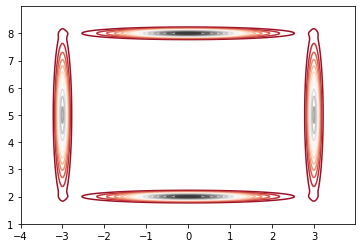

In [3]:
xx = np.arange(-4, 4, 0.01)
yy = np.arange(1, 9, 0.01)
x, y = np.mgrid[-4:4:.01, 1:9:.01]
data = np.dstack((x, y))
z = 0
zx = 0
zy = 0
for j in range(weights.size):
    z += weights[j]*multivariate_normal.pdf(data, ms[j,:], Sigmas[j,:,:])
    zx += weights[j]*norm.pdf(xx, ms[j, 0], np.sqrt(Sigmas[j, 0, 0]))
    zy += weights[j]*norm.pdf(yy, ms[j, 1], np.sqrt(Sigmas[j, 1, 1]))
plt.contour(x, y, z, 15, cmap='RdGy')

In [4]:
Niter = 1000
gamma = 0.01
N = 500
h = gamma
X0 = np.random.multivariate_normal(ms[0,:], Sigmas[0,:,:], size = N)

In [5]:
Nrep = 50
bdl = np.zeros((Nrep, Niter, d, N))
bdl_v2 = np.zeros((Nrep, Niter, d, N))
wfr_x = np.zeros((Nrep, Niter, d, N))
wfr_w = np.zeros((Nrep, Niter, N))
time_bdl = np.zeros(Nrep)
time_bdl_v2 = np.zeros(Nrep)
time_wfr = np.zeros(Nrep)

In [6]:
for i in range(Nrep):
    start = time.time()
    bdl[i, :] = algo.BDL_kernelisedPDE(gamma, Niter, ms, Sigmas, weights, N, h, X0)
    end = time.time()
    time_bdl[i] = end-start
    start = time.time()
    bdl_v2[i, :] = algo.BDL_kernelisedKL(gamma, Niter, ms, Sigmas, weights, N, h, X0)
    end = time.time()
    time_bdl_v2[i] = end-start
    start = time.time()
    wfr_x[i, :], wfr_w[i, :] = algo.SMC_WFR(gamma, Niter, ms, Sigmas, weights, X0)
    end = time.time()
    time_wfr[i] = end-start
    print(i)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49


Text(0.5, 1.0, 'WFR')

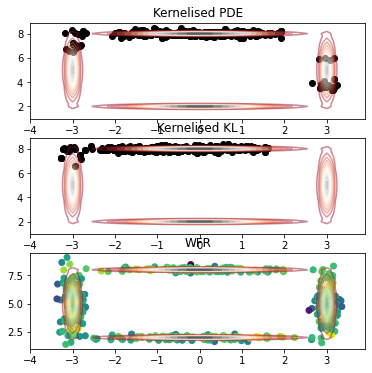

In [7]:
i = Nrep-1
x, y = np.mgrid[-4:4:.1, 1:9:.1]
data = np.dstack((x, y))
z = 0
for j in range(weights.size):
    z += weights[j]*multivariate_normal.pdf(data, ms[j,:], Sigmas[j,:,:])
plt.figure(figsize = (6,6))
plt.subplot(3, 1, 1)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(bdl[i, -1, 0, :], bdl[i, -1, 1, :], color = 'black');
plt.title('Kernelised PDE')
plt.subplot(3, 1, 2)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(bdl_v2[i, -1, 0, :], bdl_v2[i, -1, 1, :], color = 'black');
plt.title('Kernelised KL')
plt.subplot(3, 1, 3)
plt.contour(x, y, z, 15, cmap='RdGy', alpha = 0.5)
plt.scatter(wfr_x[i, -1, 0, :], wfr_x[i, -1, 1, :], c = wfr_w[i, -1, :]);
plt.title('WFR')
# plt.colorbar();
# plt.subplots_adjust(left=-1,
#                     bottom=-1,
#                     right=0.9,
#                     top=0.9,
#                     wspace=0.2,
#                     hspace=0.2)
# plt.show()
# plt.savefig("GaussianMixture4Modes.pdf")

In [8]:
true_mean = np.mean(ms, axis = 0)
true_variance = np.zeros((d, d))
for i in range(4):
    true_variance += Sigmas[i, :, :] + np.matmul((ms[i, :] - true_mean)[:, None], (ms[i, :] - true_mean)[:, None].T)
true_variance = true_variance/4

In [9]:
component = np.random.randint(4, size = N*100)
true_sample = np.zeros((N, 2))
for n in range(N):
      true_sample[n, :] = np.random.multivariate_normal(ms[component[n], :], Sigmas[component[n], :, :], size = 1)

In [10]:
mean_bdl = np.mean((np.mean(bdl[:, -1, :, :], axis = 2) - true_mean)**2)
mean_bdl_v2 = np.mean((np.mean(bdl_v2[:, -1, :, :], axis = 2) - true_mean)**2)
current_mean = np.array([np.sum(wfr_x[:, -1, 0, :]*wfr_w[:, -1, :], axis = 1), np.sum(wfr_x[:, -1, 1, :]*wfr_w[:, -1, :], axis = 1)])
mean_wfr = np.mean((current_mean.T - true_mean)**2)
cov_bdl = np.zeros(Nrep)
cov_bdl_v2 = np.zeros(Nrep)
cov_wfr = np.zeros(Nrep)
for i in range(Nrep):
    cov_bdl[i] = np.mean((np.cov(bdl[i, -1, :, :]) - true_variance)**2)
    cov_bdl_v2[i] = np.mean((np.cov(bdl_v2[i, -1, :, :]) - true_variance)**2)
    cov_wfr[i] = np.mean((np.cov(wfr_x[i, -1, :, :], aweights = wfr_w[i, -1, :]) - true_variance)**2)

In [11]:
mean_bdl, mean_bdl_v2, mean_wfr

(4.369769366260705, 4.3048309628126775, 0.006381038832185012)

In [12]:
np.mean(cov_bdl), np.mean(cov_bdl_v2), np.mean(cov_wfr)

(11.329833228500886, 11.364398236439317, 0.045888640281736316)

In [13]:
ksd_bdl = np.zeros(Nrep)
ksd_bdl_v2 = np.zeros(Nrep)
ksd_wfr = np.zeros(Nrep)
mmd_bdl = np.zeros(Nrep)
mmd_bdl_v2 = np.zeros(Nrep)
mmd_wfr = np.zeros(Nrep)
w1_bdl = np.zeros((Nrep, d))
w1_bdl_v2 = np.zeros((Nrep, d))
w1_wfr = np.zeros((Nrep, d))
for i in range(Nrep):
    mmd_bdl[i] = u.mmd_rbf(true_sample, bdl[i, -1, :, :].T)
    mmd_bdl_v2[i] = u.mmd_rbf(true_sample, bdl_v2[i, -1, :, :].T)
    mmd_wfr[i] = u.mmd_rbf(true_sample, wfr_x[i, -1, :, :].T, w = wfr_w[i, -1, :])
    scores_bdl = algo.gradient_4modes(bdl[i, -1, :, :], ms, Sigmas, weights)
    ksd_bdl[i] = u.kernel_stein_discrepancy_imq_weighted(bdl[i, -1, :, :].T, scores_bdl.T)
    scores_bdl_v2 = algo.gradient_4modes(bdl_v2[i, -1, :, :], ms, Sigmas, weights)
    ksd_bdl_v2[i] = u.kernel_stein_discrepancy_imq_weighted(bdl_v2[i, -1, :, :].T, scores_bdl_v2.T)
    scores_wfr = algo.gradient_4modes(wfr_x[i, -1, :, :], ms, Sigmas, weights)
    ksd_wfr[i] = u.kernel_stein_discrepancy_imq_weighted(wfr_x[i, -1, :, :].T, scores_wfr.T, weights = wfr_w[i, -1, :])
    for j in range(d):
        w1_bdl[i, j]  = stats.wasserstein_distance(bdl[i, -1, j, :], true_sample[:, j])
        w1_bdl_v2[i, j] = stats.wasserstein_distance(bdl_v2[i, -1, j, :], true_sample[:, j])
        w1_wfr[i, j]  = stats.wasserstein_distance(wfr_x[i, -1, j, :], true_sample[:, j], u_weights = wfr_w[i, -1, :])

In [14]:
np.mean(mmd_bdl), np.mean(mmd_bdl_v2), np.mean(mmd_wfr)

(0.34755408651280567, 0.35076209696630367, 0.004866217728822933)

In [15]:
np.mean(ksd_bdl), np.mean(ksd_bdl_v2), np.mean(ksd_wfr)

(1.854332835173358, 1.8730834694550829, 0.9844829021117009)

In [16]:
np.mean(np.mean(w1_bdl, axis = 1)), np.mean(np.mean(w1_bdl_v2, axis = 1)), np.mean(np.mean(w1_wfr, axis = 1))

(2.04401622326113, 2.039660954738912, 0.16147939406739492)

In [17]:
np.mean(time_bdl), np.mean(time_bdl_v2), np.mean(time_wfr)

(2.76825767993927, 3.021810059547424, 2.8579894590377806)

In [18]:
mmd_bdl_iter = np.zeros((Nrep, Niter))
mmd_bdl_v2_iter = np.zeros((Nrep, Niter))
mmd_wfr_iter = np.zeros((Nrep, Niter))
for i in range(Niter):
    for j in range(Nrep):
        mmd_bdl_iter[j, i] = u.mmd_rbf(true_sample, bdl[j, i, :, :].T)
        mmd_bdl_v2_iter[j, i] = u.mmd_rbf(true_sample, bdl_v2[j, i, :, :].T)
        mmd_wfr_iter[j, i] = u.mmd_rbf(true_sample, wfr_x[j, i, :, :].T, w = wfr_w[j, i, :])
eps = 0.05
np.mean(Niter - np.sum(mmd_bdl_iter<eps, axis = 1)), np.mean(Niter - np.sum(mmd_bdl_v2_iter<eps, axis = 1)), np.mean(Niter - np.sum(mmd_wfr_iter<eps, axis = 1))

(1000.0, 1000.0, 281.16)

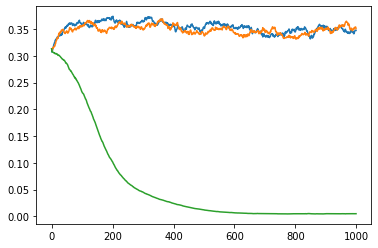

In [19]:
plt.plot(np.mean(mmd_bdl_iter, axis = 0))
plt.plot(np.mean(mmd_bdl_v2_iter, axis = 0))
plt.plot(np.mean(mmd_wfr_iter, axis = 0))